### Performing NLP to generate data

"Is anyone there?"
       
       🠋 (tokenize)
       
["Is","anyone","there","?"]

       🠋 (lower + stem)

["is","anyon","there","?"]

       🠋 (exclude punctuation characters)
       
["is","anyone","there"]

       🠋 (bag of words)
       
### X [0,0,0,1,0,1,0,1]
       

In [11]:
import nltk
from nltk.stem.porter import PorterStemmer
import json
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

stemmer = PorterStemmer()

#tokanizing the data to get the data in tokens
def tokenize(sentence):
    return nltk.word_tokenize(sentence)

#stemming each word
def stem(word):
    return stemmer.stem(word.lower())

#generating the bag of words
def bag_of_words(tokanized_sentence,all_words):
    tokanized_sentence = [stem(w) for w in tokanized_sentence]
    bag = np.zeros(len(all_words),dtype = np.float32)
    for index,w in enumerate(all_words):
        if w in tokanized_sentence:
            bag[index] = 1.0
    return bag

In [12]:
#loading data from json
with open('chatbotData.json', 'r') as f:
    data = json.load(f)

all_words = []
tags = []
xy = []
#creating arrays for different tags in json
for intent in data['intents']:
    tag = intent['tag']
    tags.append(tag)
    for pattern in intent['patterns']:
        w = tokenize(pattern)
        all_words.extend(w)
        xy.append((w,tag))

#removing unwanted symbols and punctuation characters from the data
ignore_words = ['?','!','.',',']
all_words = [stem(w) for w in all_words if w not in ignore_words]
all_words = sorted(set(all_words))
tags = sorted(set(tags))

181
['Academic Advice', 'Admission Requirements', 'Application Deadlines', 'Awards and Financial Aid', 'Business', 'Campus', 'Contact', 'Course Application', 'Courses', 'Date', 'Escalate', 'Exam Schedule', 'Health Insurance', 'Part-time', 'Payment', 'Recreational Activities', 'Registration', 'Residential Life', 'Robot', 'Start Over', 'Technology', 'Timing', 'UnderGraduate', 'Weather', 'funny', 'goodbye', 'greeting', 'housing', 'programs', 'thanks']


In [13]:
with open('test_intents.json','r') as f:
    test_intents = json.load(f)

testall_words = []
testtags =[]
testxy = []

for intent in test_intents['intents']:
    testtag = intent['tag']
    testtags.append(testtag)
    for pattern in intent['patterns']:
        testw = tokenize(pattern)
        testall_words.extend(testw)
        testxy.append((testw, testtag))

ignore_words = ['?','!','.',',']
testall_words =[stem(testw) for testw in testall_words if testw not in ignore_words]
testall_words = sorted(set(testall_words))
testtags = sorted(set(testtags))

179


In [14]:
x_train = []
y_train = []
# getting the index of the appropriate intent from the tags array and taking it as ground truth
for(pattern_sentence, tag) in xy:
    bag = bag_of_words(pattern_sentence, all_words)
    x_train.append(bag)

    label = tags.index(tag)
    y_train.append(label)

x_train = np.array(x_train)
y_train = np.array(y_train)

In [15]:
x_test = []
y_test = []

for(pattern_sentence,tag) in testxy:
    testbag = bag_of_words(pattern_sentence, all_words)
    x_test.append(testbag)
    testlabel = testtags.index(tag)
    y_test.append(testlabel)

test_set = np.array(x_test)
y_test = np.array(y_test)

In [16]:
import torch.nn.functional as F
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size) 
        self.l2 = nn.Linear(hidden_size, hidden_size) 
        self.l3 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        #Adding Dropout Layer
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.l3(out)
        return out

Epoch [100/1000], Loss: 73.6872
Epoch [200/1000], Loss: 130.6462
Epoch [300/1000], Loss: 168.6117
Epoch [400/1000], Loss: 200.5398
Epoch [500/1000], Loss: 228.3225
Epoch [600/1000], Loss: 253.7305
Epoch [700/1000], Loss: 274.4767
Epoch [800/1000], Loss: 296.1294
Epoch [900/1000], Loss: 318.9557
Epoch [1000/1000], Loss: 342.7564
[0.0, 25.0, 75.0, 100.0, 50.0, 25.0, 75.0, 50.0, 75.0, 75.0]
final loss: 342.7564
training complete. file saved to data.pth


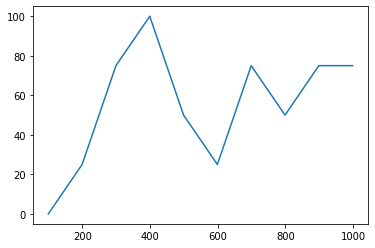

In [17]:
# Hyper-parameters 
num_epochs = 1000
batch_size = 8
learning_rate = 0.001
input_size = len(x_train[0])
hidden_size = 8
output_size = len(tags)
class ChatDataset(Dataset):
    def __init__(self,x,y):
        self.n_samples = len(x)
        self.x_data = x
        self.y_data = y
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    
    def __len__(self):
        return self.n_samples

#creating a loader to automatically load data with variable batch size into the model
dataset = ChatDataset(x_train,y_train)
train_loader = DataLoader(dataset=dataset,batch_size = batch_size, shuffle = True, num_workers = 0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNet(input_size, hidden_size, output_size).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

correct= 0
train_accuracy = []
epoch_val = []
# Train the model
the_last_loss = 100
patience = 2
trigger_times = 0
# to track the training loss as the model trains
train_losses = []
for epoch in range(num_epochs):
    l1_regularization, l2_regularization = torch.tensor(0), torch.tensor(0)
    for (words, labels) in train_loader:
        words = words.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(words)
        loss = criterion(outputs, labels.long())
        #Regularization
        for param in model.parameters():
            l1_regularization += (torch.norm(param, 1)**2).long()
            l2_regularization += (torch.norm(param, 2)**2).long()
        loss = loss + (0.0001 * l1_regularization) + (0.0001 * l2_regularization)
        loss.backward()
        optimizer.step()
    #Getting accuracy of the trained model
    y_pred = torch.max(outputs,1)[1]
    correct = (y_pred == labels).sum().item()
    accuracy = 100*(correct / outputs.shape[0])
    train_losses.append(loss.item())
       
    if (epoch+1) % 100 == 0:
        print (f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        epoch_val.append(epoch+1/num_epochs)
        train_accuracy.append(accuracy)
            
            
    train_loss = np.average(train_losses)

print(train_accuracy)
print(f'final loss: {loss.item():.4f}')
data = {
"model_state": model.state_dict(),
"input_size": input_size,
"hidden_size": hidden_size,
"output_size": output_size,
"all_words": all_words,
"tags": tags
}

FILE = "data.pth"
torch.save(data, FILE)
print(f'training complete. file saved to {FILE}')
plt.plot(epoch_val,train_accuracy)

### Training Data ###
                                       ### bag of words ###
                                         
          all words 🠊   ["Hi", "How", "are", "you", "bye", "see", "later"]
               tags 🠊   ['Courses', 'Menu', 'Start Over', 'funny', 'goodbye', 'greeting', 'thanks']
       
               "Hi" 🠊   [1, 0, 0, 0, 0, 0, 0]
      "How are you" 🠊   [0, 1, 1, 1, 0, 0, 0]               5(greeting)
     
              "Bye" 🠊   [0, 0, 0, 0, 1, 0, 0]
    "See you later" 🠊   [0, 0, 0, 1, 0, 1, 1]               4(goodbye)
    
                               
                                  X                              Y (ground truth)

### What are the parameters you are controlling?
The parameters we are controlling in the data:

1. Train-test split ratio

2. Batch Size

3. Choice of activation function in a neural network (nn) layer (e.g. Sigmoid, ReLU, Tanh)

4. Choice of optimization algorithm (e.g., gradient descent, stochastic gradient descent, or Adam optimizer)

5. The choice of cost or loss function the model will use

6. Number of hidden layers in a neural network

7. Learning rate in optimization algorithms (e.g. gradient descent)

8. Number of iterations (epochs) in training a neural network

### How do you get the ground truth?
First, we have generated bag of words by putting all the words of the sentence in a bag. 
  sentence = ["hello", "how", "are", "you"]
  words = ["hi", "hello", "I", "you", "bye", "thank", "cool"]
We are generating the ground truth by comparing the words of the sentence to the bag of words. 
bog   = [  0 ,    1 ,    0 ,   1 ,    0 ,    0 ,      0]
After the comparison, we have assigned the sentence to a particular tag. The tag is considered as the round truth.
bog   = [  0 ,    1 ,    0 ,   1 ,    0 ,    0 ,      0]. 🠊 ‘greetings’ [GROUND TRUTH]

### Is this an abstraction of the data described in your original proposal?
In our original proposal, we aimed at creating chatbot for Dalhousie covering courses, payments etc. The data here is the abstraction of the data we define. We will expand it in our project later covering more areas.

Epoch [100], Test Accuracy of the model: 12.5000
Epoch [200], Test Accuracy of the model: 25.0000
Epoch [300], Test Accuracy of the model: 37.5000
Epoch [400], Test Accuracy of the model: 37.5000
Epoch [500], Test Accuracy of the model: 37.5000
Epoch [600], Test Accuracy of the model: 37.5000
Epoch [700], Test Accuracy of the model: 37.5000
Epoch [800], Test Accuracy of the model: 50.0000
Epoch [900], Test Accuracy of the model: 50.0000
Epoch [1000], Test Accuracy of the model: 75.0000
[12.5, 25.0, 37.5, 37.5, 37.5, 37.5, 37.5, 50.0, 50.0, 75.0]


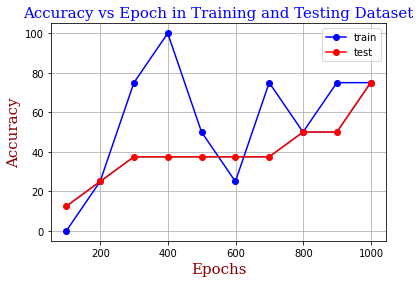

In [23]:
test_dataset = ChatDataset(test_set,y_test)
test_loader = DataLoader(dataset=test_dataset,batch_size = batch_size, shuffle = True, num_workers = 0)

# loading the saved model to test the accuracy with new data
FILE = "data.pth"
data = torch.load(FILE)
model_state = data["model_state"]

model = NeuralNet(input_size, hidden_size, output_size).to(device)
model.load_state_dict(model_state)
model.eval()

epoch_val = []
num_epochs=1000
def test():
    # to track the validation loss as the model trains
    val_losses = []
    accuracy_val =[]
    with torch.no_grad():
        for epoch in range(num_epochs):
            last_loss = 0
            for (words, labels) in test_loader:
                words = words.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(words)
                # Using sigmoid to get probabilities in the output
                output = torch.sigmoid(outputs)
                loss = criterion(output, labels.long())
                y_pred = torch.max(outputs,1)[1]
                correct = (y_pred == labels).sum().item()
                accuracy = 100*(correct / outputs.shape[0])
                val_losses.append(loss.item())
            if (epoch+1) % 100 == 0:
                print(f'Epoch [{epoch+1}], Test Accuracy of the model: %.4f' % accuracy)
                accuracy_val.append(accuracy)
                epoch_val.append(epoch+1/num_epochs)
            
            val_loss = np.average(val_losses)
    return accuracy_val

accuracy_val = test()
print(accuracy_val)
plt.plot(epoch_val,accuracy_val)

font1 = {'family':'serif','color':'blue','size':15}
font2 = {'family':'serif','color':'darkred','size':15}
plt.plot(epoch_val, train_accuracy, 'o-', color='blue', label='train')
plt.plot(epoch_val, accuracy_val, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel("Epochs", fontdict = font2)
plt.ylabel("Accuracy", fontdict = font2)
plt.title("Accuracy vs Epoch in Training and Testing Dataset", fontdict = font1)
plt.show()

### Overfitting 
Our model currently shows over-fitting. It occurs when a statistical model fits exactly against its training data. When this happens, the algorithm unfortunately cannot perform accurately against unseen data, defeating its purpose. Generalization of a model to new data is ultimately what allows us to use machine learning algorithms every day to make predictions and classify data.

When the accuracy of your training dataset, the dataset used to teach the model is greater than your testing accuracy. In terms of ‘loss’, overfitting reveals itself when the model has a low error in the training set and a higher error in the testing set. 

This can be identified visually in the abive graph. We have plotted loss and accuracy metrics and seeing where the performance metrics converge for both training and testing datasets.

### How would we prevent overfitting
To improve the accuracy of our model, we can essentially do two things
•	Improve our model
•	Improve our data
Improving our model
 We can adopt three common ways to adapt our model in order to prevent overfitting.

#### 1. Simplifying the model
The first step that we can take when dealing with overfitting is to decrease the complexity of the model. To decrease the complexity of the model, we can simply remove layers or reduce the number of neurons in order to make our network smaller. There is no general rule on how much to remove or how big your network should be. But, if our network is overfitting, we can try making it smaller.

#### 2. Adding Dropout Layers
Dropout Layers can be an easy and effective way to prevent overfitting in your models. A dropout layer randomly drops some of the connections between layers. This helps to prevent overfitting, because if a connection is dropped.

#### 3. Early Stopping
Another way to prevent overfitting is to stop our training process early: Instead of training for a fixed number of epochs, we can stop as soon as the validation loss rises — because, after that, our model will generally only get worse with more training.

In [ ]:
# chat.py
import random
import json

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open('chatbotData.json', 'r') as json_data:
    intents = json.load(json_data)

FILE = "data.pth"
data = torch.load(FILE)

input_size = data["input_size"]
hidden_size = data["hidden_size"]
output_size = data["output_size"]
all_words = data['all_words']
tags = data['tags']
model_state = data["model_state"]

model = NeuralNet(input_size, hidden_size, output_size).to(device)
model.load_state_dict(model_state)
model.eval()

bot_name = "SRS Bot"
print("Let's chat! (type 'quit' to exit)")
while True:
    # sentence = "do you use credit cards?"
    sentence = input("You: ")
    if sentence == "quit":
        break

    sentence = tokenize(sentence)
    X = bag_of_words(sentence, all_words)
    X = X.reshape(1, X.shape[0])
    X = torch.from_numpy(X).to(device)

    output = model(X)
    _, predicted = torch.max(output, dim=1)

    tag = tags[predicted.item()]

    probs = torch.softmax(output, dim=1)
    prob = probs[0][predicted.item()]
    # Experiment on this number- False positive vs false negative. Reasonable number would be half-0.5
    if prob.item() > 0.50:
        for intent in intents['intents']:
            if tag == intent["tag"]:
                print(f"{bot_name}: {random.choice(intent['responses'])}")
    else:
        print(f"{bot_name}: I do not understand...")

Let's chat! (type 'quit' to exit)
